## Pipeline:
1.Get ACS **tract level data** by APIs

2.Get mobility **tract level** pattern data from SafeGraph

3.Get New York Census Tract data from arcgis hub

In [167]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import geopandas as gpd

from shapely.geometry import shape, Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

import geojson
import json

plt.rcParams['figure.figsize'] = [10, 10]
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

pd.set_option('display.float_format', '{:.2f}'.format)


### 1. NYC base map on tract level

https://www1.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page


In [168]:
### tract level data:
url='https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

In [169]:
import geojson
r_1=requests.get(url)
features_1 = geojson.loads(r_1.text)

In [170]:
GEOID,geometry=[],[]

for e in features_1['features']: 
    GEOID.append(e['properties']["GEOID"])
    ps = shape(e['geometry'])
    geometry.append(
        MultiPolygon(ps) if isinstance(ps, list) else ps
    )

boundary = pd.DataFrame([GEOID,geometry]).T
boundary.columns=['GEO_ID','geometry']
boundary['tract_id']=boundary['GEO_ID'].str[:11].astype('int64')


In [171]:
boundary_gpd= gpd.GeoDataFrame(boundary, geometry='geometry', crs="EPSG:4326")
boundary_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

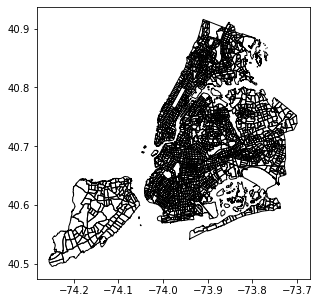

In [172]:
fig, ax = plt.subplots(figsize=(5,5))
ax = boundary_gpd.plot(ax=ax, facecolor='none', edgecolor='black')
ax

### 2. ACS 5-year data based on tract level

In [173]:
# TotalPop = B25026_001E, 

# Whites = B02001_002E,
# Black or African American = B02001_003E
# American Indian and Alaska Native = B02001_004E
# Asian = B02001_005E

# FemaleBachelors = B15001_050E, 
# MaleBachelors = B15001_009E,

# MedHHInc = B19013_001E, 
# MedRent = B25058_001E,

# TotalPoverty = B06012_002E,

# TotalVacant = B25002_003E,
# TotalUnit = B25001_001E,

# MedRent = B25058_001E,
# MedHHInc = B19013_001E, 


In [174]:
http='https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B25026_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B15001_050E,B15001_009E,B06012_002E,B25002_003E,B25001_001E,B25058_001E,B19013_001E&for=tract:*&in=state:36%20county:085,081,061,005,047&key=9e5876bd913ec7705eb4b93ee17937abb9bf8d2b'

In [175]:
r_2=requests.get(http)
features_2 = r_2.json()
acs=pd.DataFrame.from_records(features_2)
new_header=acs.iloc[0]
acs.head()# features.to_csv('census.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NAME,GEO_ID,B25026_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B15001_050E,B15001_009E,B06012_002E,B25002_003E,B25001_001E,B25058_001E,B19013_001E,state,county,tract
1,"Census Tract 361, Queens County, New York",1400000US36081036100,2231,284,412,0,323,16,8,290,200,818,1346,47419,36,081,036100
2,"Census Tract 363, Queens County, New York",1400000US36081036300,1761,285,263,0,115,7,9,359,235,732,1441,57802,36,081,036300
3,"Census Tract 371, Queens County, New York",1400000US36081037100,1320,157,310,2,200,0,5,158,191,593,1769,67419,36,081,037100
4,"Census Tract 377, Queens County, New York",1400000US36081037700,3616,1100,268,16,152,11,11,439,128,903,1647,71728,36,081,037700


In [176]:
new_header=acs.iloc[0]
acs.columns=new_header
acs=acs[1:]
acs=acs.rename({
                'B25026_001E':'total_pop', 
                'B02001_002E':'Whites',
                'B02001_003E':'Black',
                'B02001_004E':'Indian',
                'B02001_005E':'Asian',
    
                'B15001_050E':'FemaleBachelors', 
                'B15001_009E':'MaleBachelors',
    
                'B19013_001E':'MedHHInc',
                'B25058_001E':'MedRent',
    
                'B06012_002E':'TotalPoverty',
                'B25002_003E':'TotalVacant',
                'B25001_001E':'TotalUnit',

               }, axis='columns')
acs=acs.dropna()
acs['tract_id']=pd.to_numeric(acs['GEO_ID'].str[9:])
acs.head()

,NAME,GEO_ID,total_pop,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,state,county,tract,tract_id
1,"Census Tract 361, Queens County, New York",1400000US36081036100,2231,284,412,0,323,16,8,290,200,818,1346,47419,36,081,036100,36081036100
2,"Census Tract 363, Queens County, New York",1400000US36081036300,1761,285,263,0,115,7,9,359,235,732,1441,57802,36,081,036300,36081036300
3,"Census Tract 371, Queens County, New York",1400000US36081037100,1320,157,310,2,200,0,5,158,191,593,1769,67419,36,081,037100,36081037100
4,"Census Tract 377, Queens County, New York",1400000US36081037700,3616,1100,268,16,152,11,11,439,128,903,1647,71728,36,081,037700,36081037700
5,"Census Tract 379, Queens County, New York",1400000US36081037900,6847,2659,378,16,638,45,0,1115,40,1423,1551,72799,36,081,037900,36081037900


In [177]:
['TotalPop', 
                'Whites',
                'Black',
                'Indian',
                'Asian',
    
                'FemaleBachelors', 
               'MaleBachelors',
    
                'MedHHInc',
               'MedRent',
    
                'TotalPoverty',
                'TotalVacant',
                'TotalUnit']

acs.dtypes

0
NAME               object
GEO_ID             object
total_pop          object
Whites             object
Black              object
Indian             object
Asian              object
FemaleBachelors    object
MaleBachelors      object
TotalPoverty       object
TotalVacant        object
TotalUnit          object
MedRent            object
MedHHInc           object
state              object
county             object
tract              object
tract_id            int64
dtype: object

In [178]:
acs['total_pop']=acs['total_pop'].astype('int64')
acs['Whites']=acs['Whites'].astype('int32')
acs['Black']=acs['Black'].astype('int64')
acs['Indian']=acs['Indian'].astype('int64')
acs['Asian']=acs['Asian'].astype('int64')
acs['FemaleBachelors']=acs['FemaleBachelors'].astype('int64')
acs['MaleBachelors']=acs['MaleBachelors'].astype('int64')
acs['MedHHInc']=acs['MedHHInc'].astype('int64')
acs['MedRent']=acs['MedRent'].astype('int64')
acs['TotalPoverty']=acs['TotalPoverty'].astype('int64')
acs['TotalVacant']=acs['TotalVacant'].astype('int64')
acs['TotalUnit']=acs['TotalUnit'].astype('int64')

In [179]:
acs.dtypes

0
NAME               object
GEO_ID             object
total_pop           int64
Whites              int32
Black               int64
Indian              int64
Asian               int64
FemaleBachelors     int64
MaleBachelors       int64
TotalPoverty        int64
TotalVacant         int64
TotalUnit           int64
MedRent             int64
MedHHInc            int64
state              object
county             object
tract              object
tract_id            int64
dtype: object

In [180]:
# verfication
acs.values[:4,2:3]
acs.quantile(q=0.25,axis=0)
bot_quantile=np.quantile(acs.values[:4,2:3],0.25,axis=0)
# bot_quantile=bot_quantile[0]
bot_quantile

array([1650.75], dtype=object)

In [181]:
top_quantile=np.quantile(acs.values[:,2:3],0.75,axis=0)
top_quantile=top_quantile[0]
bot_quantile=np.quantile(acs.values[:,2:3],0.25,axis=0)
bot_quantile=bot_quantile[0]
acs.loc[acs['MedHHInc'] >=top_quantile, 'income_quantile'] = 'True'
acs.loc[acs['MedHHInc'] <=bot_quantile, 'income_quantile'] = 'False'
acs

,NAME,GEO_ID,total_pop,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,state,county,tract,tract_id,income_quantile
1,"Census Tract 361, Queens County, New York",1400000US36081036100,2231,284,412,0,323,16,8,290,200,818,1346,47419,36,081,036100,36081036100,True
2,"Census Tract 363, Queens County, New York",1400000US36081036300,1761,285,263,0,115,7,9,359,235,732,1441,57802,36,081,036300,36081036300,True
3,"Census Tract 371, Queens County, New York",1400000US36081037100,1320,157,310,2,200,0,5,158,191,593,1769,67419,36,081,037100,36081037100,True
4,"Census Tract 377, Queens County, New York",1400000US36081037700,3616,1100,268,16,152,11,11,439,128,903,1647,71728,36,081,037700,36081037700,True
5,"Census Tract 379, Queens County, New York",1400000US36081037900,6847,2659,378,16,638,45,0,1115,40,1423,1551,72799,36,081,037900,36081037900,True
6,"Census Tract 413, Queens County, New York",1400000US36081041300,4696,1609,63,88,957,26,11,1245,25,1026,1616,55046,36,081,041300,36081041300,True
7,"Census Tract 200, Bronx County, New York",1400000US36005020000,4675,745,574,61,1102,18,35,1190,129,1598,1156,40184,36,005,020000,36005020000,True
8,"Census Tract 205.01, Bronx County, New York",1400000US36005020501,6958,827,2153,40,55,0,16,3124,54,2912,679,17601,36,005,020501,36005020501,True
9,"Census Tract 205.02, Bronx County, New York",1400000US36005020502,2154,168,832,0,3,16,0,753,49,975,804,18919,36,005,020502,36005020502,True
10,"Census Tract 209, Bronx County, New York",1400000US36005020900,4238,539,1862,0,11,30,9,1435,67,1799,969,31190,36,005,020900,36005020900,True


In [182]:
# acs['majority_white'] = np.where((acs['white_pop']/acs['total_pop'])>=0.5, True, False)
acs['pctWhite'] = (acs['Whites']/acs['total_pop'])
acs['pctBlack'] = (acs['Black']/acs['total_pop'])
acs['pctIndian'] = (acs['Indian']/acs['total_pop'])
acs['pctAsian'] = (acs['Asian']/acs['total_pop'])
acs['pctVacant'] = (acs['TotalVacant']/acs['TotalUnit'])
acs['pctBachelors'] = (acs['FemaleBachelors']+acs['MaleBachelors'])/acs['total_pop']
acs['pctPoverty '] = acs['TotalPoverty']/acs['total_pop']


### todo: how to use bachelor and income blow poverty data
acs.head()
acs.to_csv('../data_save/acs.csv')

### 3 .Pattern data from SafeGraph

##### 3.1 business type aggravagation from 2-digit naics code 

In [183]:
df_mar_19=pd.read_csv('../data_save/df_mar_19.csv')  
df_mar_20=pd.read_csv('../data_save/df_mar_20.csv')  
df_mar_21=pd.read_csv('../data_save/df_mar_21.csv') 

##### 3.3 groupby tract_id and calculate sum of:

1. raw_visit_counts, 

2. median_dwell,

3. raw_visitor_counts

In [153]:
tract_mar_19=df_mar_19.groupby(by=['tract_id'])['raw_visit_counts'].sum()
print(tract_mar_19.shape)
tract_mar_19.head()
tract_mar_19.to_csv('../data_save/tract_mar_19.csv')

(1292,)


In [154]:
tract_mar_20=df_mar_20.groupby(by=['tract_id'])['raw_visit_counts'].sum()
print(tract_mar_20.shape)
tract_mar_20.to_csv('../data_save/tract_mar_20.csv')

(1281,)


In [155]:
tract_mar_21=df_mar_21.groupby(by=['tract_id'])['raw_visit_counts'].sum()
print(tract_mar_21.shape)
tract_mar_21.head()
tract_mar_21.to_csv('../data_save/tract_mar_21.csv')

(1276,)



### 4 merge pattern data and acs 5-year data based on tract_id
### 5 merge pattern_acs(acs+pattern data) with boundary(NYC base map) by tract_id

In [156]:
def spatial_process(raw_data):
    # merge pattern data and acs 5-year data based on tract_id
    pattern_acs = pd.merge(raw_data, acs,how='left',left_on=['tract_id'],right_on=['tract_id'])
    
    # merge pattern_acs(acs+pattern data) with boundary(NYC base map) by tract_id
    data_merge=pd.merge(pattern_acs, boundary,how='inner',left_on=['tract_id'],right_on=['tract_id'])
    
    data_merge.loc[data_merge["county"] == '005','county'] = 'Bronx'
    data_merge.loc[data_merge["county"] == '047','county'] = 'Brooklyn'
    data_merge.loc[data_merge["county"] == '061','county'] = 'Manhattan'
    data_merge.loc[data_merge["county"] == '081','county'] = 'Queens'
    data_merge.loc[data_merge["county"] == '085','county'] = 'Staten Dislands'
    
    # transfer to geodata 
    gdf= gpd.GeoDataFrame(data_merge, geometry='geometry', crs="EPSG:4326")
    return pattern_acs,data_merge,gdf


In [157]:
_,_,gdf_mar_19=spatial_process(tract_mar_19)
gdf_mar_19.head()
gdf_mar_19.to_csv('../data_save/gdf_mar_19.csv')

In [158]:
_,_,gdf_mar_20=spatial_process(tract_mar_20)
gdf_mar_20.head()
gdf_mar_20.to_csv('../data_save/gdf_mar_20.json')


In [159]:
_,_,gdf_mar_21=spatial_process(tract_mar_21)
gdf_mar_21.head()
gdf_mar_21.to_csv('../data_save/gdf_mar_21.csv')
gdf_mar_21.head()

,tract_id,raw_visit_counts,NAME,GEO_ID_x,total_pop,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,MedHHInc,MedRent,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,state,county,tract,pctWhite,pctBlack,pctIndian,pctAsian,pctVacant,pctBachelors,pctPoverty,GEO_ID_y,geometry
0,36005000200,493,"Census Tract 2, Bronx County, New York",1400000US36005000200,4527.00,1919.00,1371.00,0.00,75.00,0.00,0.00,51100.00,1454.00,1017.00,157.00,1499.00,1454.00,51100.00,36,Bronx,000200,0.42,0.30,0.00,0.02,0.10,0.00,0.22,36005000200,"POLYGON ((-73.85652 40.80525, -73.85653 40.805..."
1,36005000400,2008,"Census Tract 4, Bronx County, New York",1400000US36005000400,5503.00,2436.00,1677.00,17.00,208.00,67.00,0.00,78409.00,1241.00,462.00,141.00,2183.00,1241.00,78409.00,36,Bronx,000400,0.44,0.30,0.00,0.04,0.06,0.01,0.08,36005000400,"POLYGON ((-73.84611 40.81311, -73.84647 40.812..."
2,36005001600,81,"Census Tract 16, Bronx County, New York",1400000US36005001600,5586.00,1884.00,2539.00,0.00,76.00,24.00,39.00,34093.00,953.00,1522.00,45.00,2016.00,953.00,34093.00,36,Bronx,001600,0.34,0.45,0.00,0.01,0.02,0.01,0.27,36005001600,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
3,36005002300,700,"Census Tract 23, Bronx County, New York",1400000US36005002300,4297.00,584.00,1616.00,49.00,0.00,16.00,0.00,18688.00,436.00,1695.00,0.00,1914.00,436.00,18688.00,36,Bronx,002300,0.14,0.38,0.01,0.00,0.00,0.00,0.39,36005002300,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
4,36005002400,2986,"Census Tract 24, Bronx County, New York",1400000US36005002400,155.00,65.00,90.00,0.00,0.00,0.00,0.00,-666666666.00,-666666666.00,0.00,0.00,38.00,-666666666.00,-666666666.00,36,Bronx,002400,0.42,0.58,0.00,0.00,0.00,0.00,0.00,36005002400,"POLYGON ((-73.87050 40.82037, -73.87044 40.820..."


In [25]:
import shapely
def df_to_geojson(df, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Polygon',
                               'coordinates':[]}}
        
        feature['geometry']= shapely.geometry.mapping(row.geometry)
        for prop in ['raw_visit_counts','income','total_pop','white_pop','bachelor','income_below_poverty','income_below_poverty','majority_white','tract_id']:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

geojson_19 =df_to_geojson(gdf_mar_19)

from geojson import Point, Feature, FeatureCollection, dump

with open('../data_save/gdf_mar_19.geojson', 'w') as f:
   dump(geojson_19, f)

geojson_20 =df_to_geojson(gdf_mar_20)

with open('../data_save/gdf_mar_20.geojson', 'w') as f:
   dump(geojson_20, f)

geojson_20 =df_to_geojson(gdf_mar_21)

with open('../data_save/geojson_21.geojson', 'w') as f:
   dump(geojson_20, f)

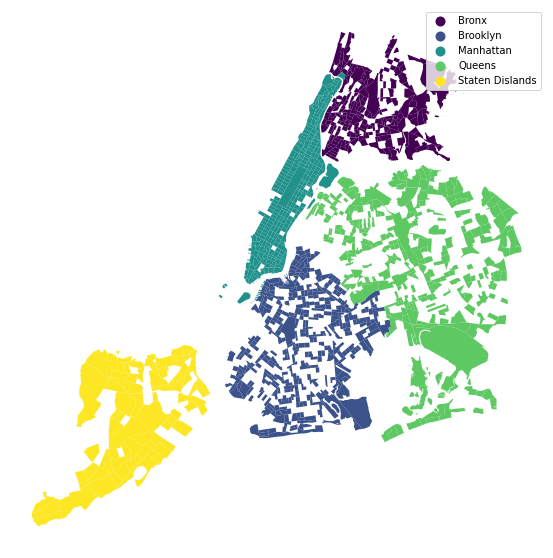

In [30]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
gdf_mar_20.plot(ax=ax, column='county',categorical='True',cmap='viridis' , legend=True)
# Format
# ax.set_title("Map of NYC", fontsize=16)
ax.set_axis_off()
fig.savefig('../fig/NYC_map.jpg')

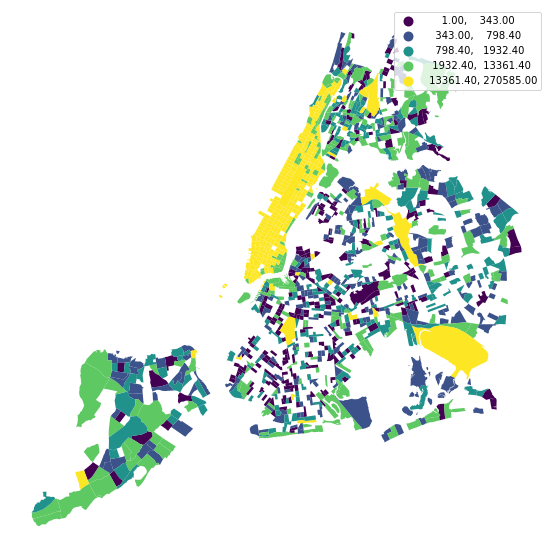

In [31]:

fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
plot1=gdf_mar_19.plot(ax=ax, column='raw_visit_counts',
                    scheme='Quantiles',cmap='viridis',
                    legend=True,
#                     legend_kwargs={ 'loc': 'lower right'},
                   )

# Format
# ax.set_title("visit count of NY in march 2019", fontsize=16)

# ax.legend(loc='lower left')
ax.set_axis_off()
fig.savefig('../fig/raw_visit_counts_mar_2019.jpg')

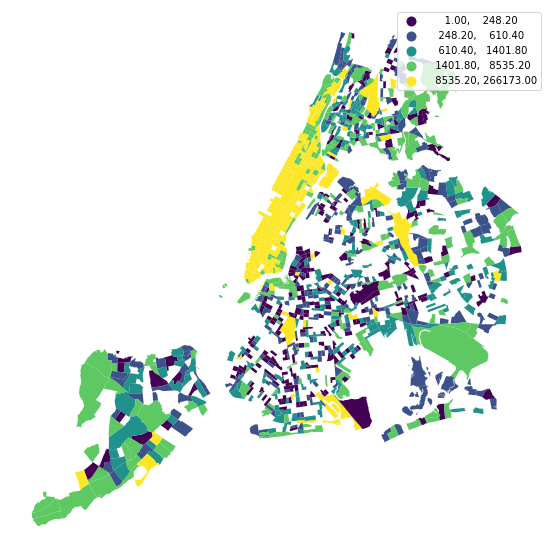

In [32]:

fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
plot1=gdf_mar_20.plot(ax=ax, column='raw_visit_counts',
                    scheme='Quantiles',cmap='viridis',
                    legend=True,
#                     legend_kwargs={ 'loc': 'lower right'},
                   )

# Format
# ax.set_title("visit count of NY in march 2020", fontsize=16)

# ax.legend(loc='lower left')
ax.set_axis_off()
fig.savefig('../fig/raw_visit_counts_mar_2020.jpg')

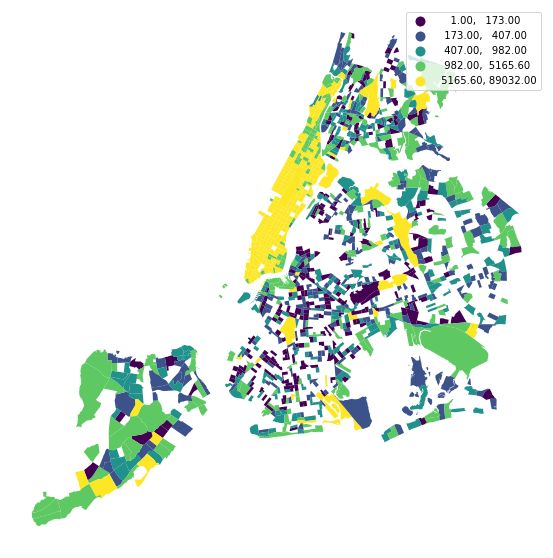

In [33]:

fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
plot1=gdf_mar_21.plot(ax=ax, column='raw_visit_counts',
                    scheme='Quantiles',cmap='viridis',
                    legend=True,
#                     legend_kwargs={ 'loc': 'lower right'},
                   )

# Format
# ax.set_title("visit count of NY in march 2021", fontsize=16)

# ax.legend(loc='lower left')
ax.set_axis_off()
fig.savefig('../fig/raw_visit_counts_mar_2021.jpg')

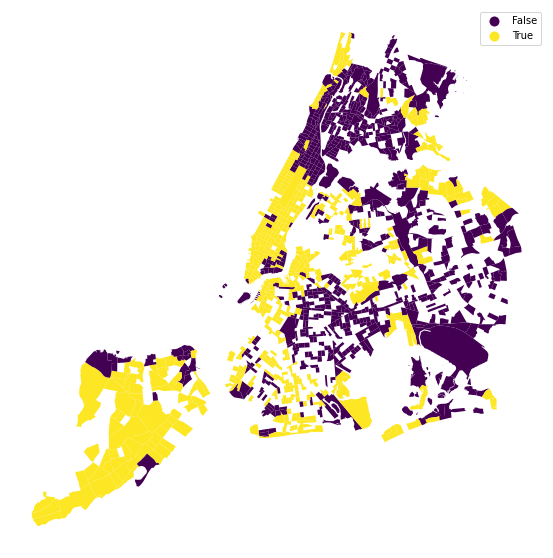

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
gdf_mar_21.plot(ax=ax, column='majority_white',categorical='True',cmap="viridis", legend=True)

# Format
# ax.set_title("majority_white of NY", fontsize=16)
ax.set_axis_off()
fig.savefig('../fig/majority_white.jpg')

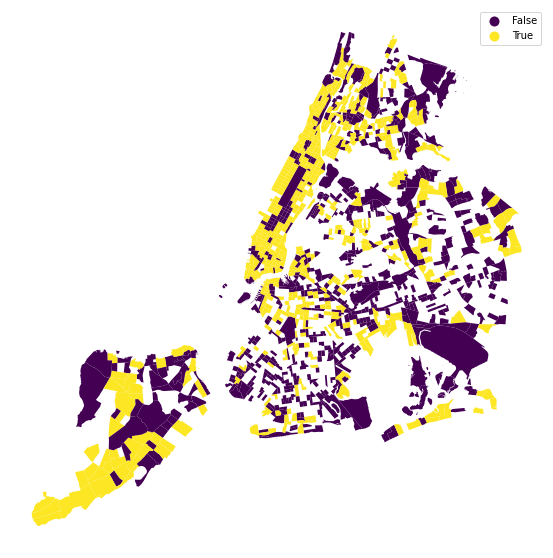

In [35]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth
gdf_mar_21.plot(ax=ax, column='income_high',categorical='True', cmap="viridis", legend=True)

# Format
# ax.set_title("income higher than average in NY", fontsize=16)
ax.set_axis_off()
fig.savefig('../fig/income_high.jpg')

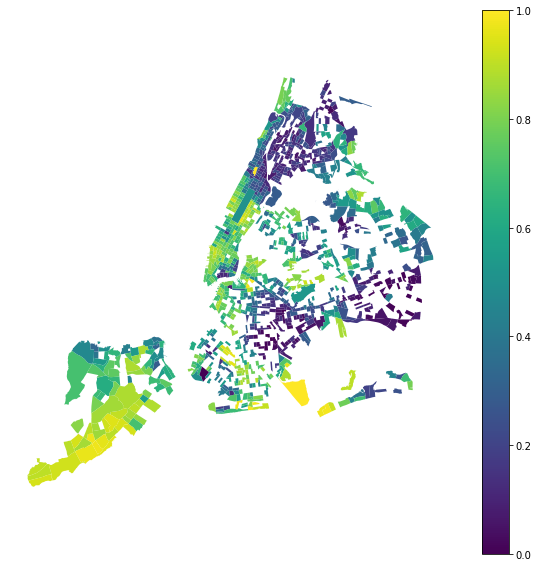

In [36]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth
gdf_mar_21.plot(ax=ax, column='white_percent',cmap="viridis", legend=True)

# Format
# ax.set_title("White percent of NY", fontsize=16)
ax.set_axis_off()

fig.savefig('../fig/white_percent.jpg')

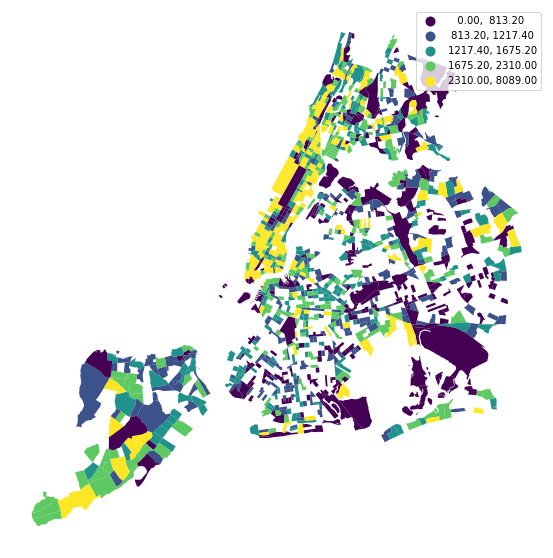

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth
gdf_mar_21.plot(ax=ax, column='income',scheme='Quantiles',cmap="viridis", legend=True)
# Format
# ax.set_title("income of NY", fontsize=16)
ax.set_axis_off()
fig.savefig('../fig/income.jpg')